# 5LSL0 Assignment 4: Deep Unfolding
---

In [1]:
# libraries
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# local imports
import MNIST_dataloader
from Fast_MRI_dataloader import *

# set torches random seed
torch.random.manual_seed(0)

# define parameters
data_loc1 = 'D://5LSL0-Datasets'
data_loc2 = 'D://5LSL0-Datasets//Fast_MRI_Knee'

## Week 1
### Loading MNIST dataset

Number of training batches: 938
Number of test batches: 157


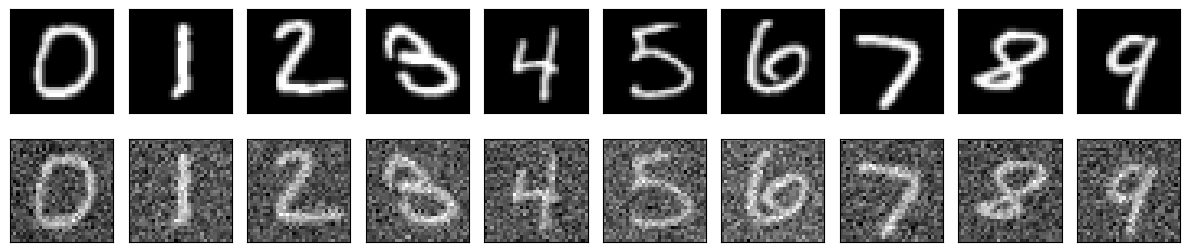

In [2]:
batch_size = 64

# get dataloader
train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc1, batch_size)

print(f"Number of training batches: {len(train_loader)}"
        f"\nNumber of test batches: {len(test_loader)}")

# get some examples as the first 10 correspond to the digits 0-9
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# show the examples in a plot
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

In [3]:
# Access the entire training and test set for later use
clean_train = train_loader.dataset.Clean_Images # 60000 images
noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

clean_test  = test_loader.dataset.Clean_Images # 10000 images
noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# Access 10 examples as representations for all digits
clean_example = clean_test[0:10,:,:,:]
noisy_example = noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

## Exercise 1 - ISTA

### (a) [3 pt] Create a Python function that implements ISTA for MNIST denoising. 

Make sure the function takes as inputs: step size μ, shrinkage parameter λ, number of iteration K, and measurements (batch of MNIST images) y. It should output the final batch of reconstructions xK .

hint: the images are normalized between -1 and 1, which means the background of the
images is not at zero. Think about how to still aply ISTA correctly.

In [4]:
# Soft thresholding function
def softthreshold(x, shrinkage):
    return torch.sign(x) * torch.max(torch.abs(x) - shrinkage, torch.tensor(0.0))

# ISTA function
def ISTA(mu, shrinkage, K, y):
    # Initialize x to be the same as y
    x = y.clone() 
    
    # Iteratively apply the soft thresholding function
    for _ in tqdm(range(K)):
        # Compute the gradient
        x = x - mu * (x - y)
        # Shrinkage step
        x = softthreshold(x, mu * shrinkage)
    
    # Normalize the final batch of reconstructions to be between -1 and 1
    x = 2 * (x - x.min()) / (x.max() - x.min()) - 1
    
    # Return the final batch of reconstructions
    return x

### (b) [2 pt] Use your ISTA algorithm on 10 example images. 

Show them in a figure consisting of 10 collumns (1 per digit) and 3 rows. Row 1 should contain the noisy
measurement, row 2 the reconstruction, and row 3 the actual ground truth target.
You will have to play with the values for μ, λ, and K. Explain what you see.

values of noisy_example: -2.727461099624634, 2.337520122528076


100%|██████████| 10/10 [00:00<00:00, 9995.96it/s]


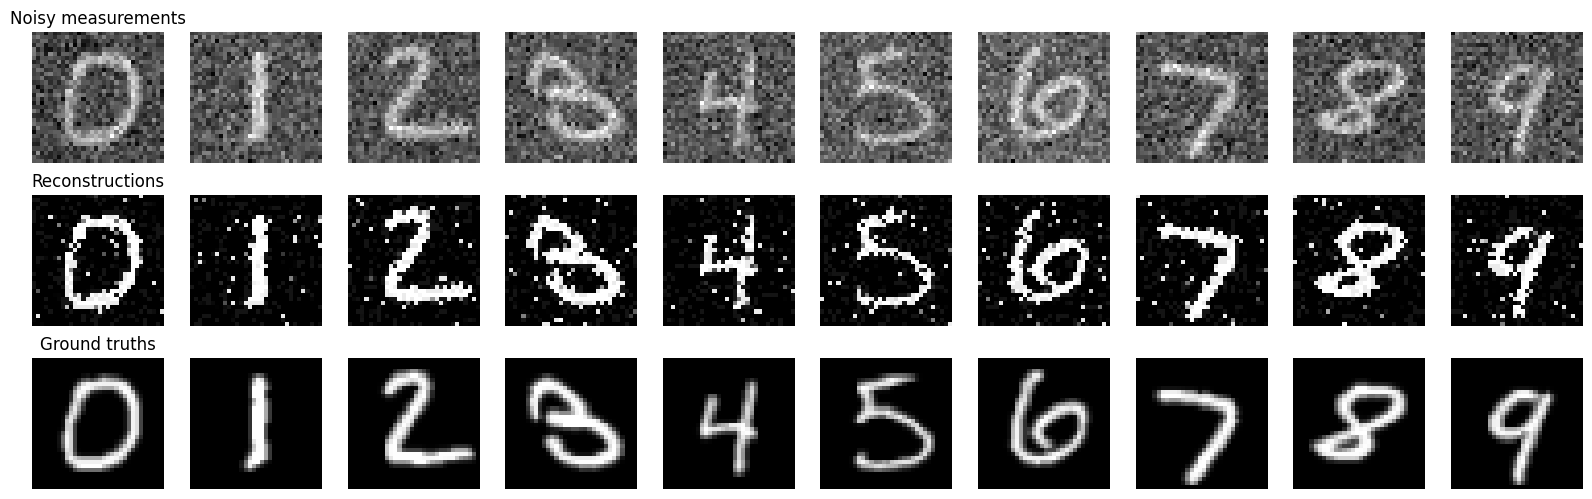

In [5]:
mu = 5.0
shrinkage = 0.01
K = 10

#noisy_example = 2 * (noisy_example - noisy_example.min()) / (noisy_example.max() - noisy_example.min()) - 1
print(f"values of noisy_example: {noisy_example.min()}, {noisy_example.max()}")

# Apply the ISTA algorithm to the noisy example images
x_reconstructed = ISTA(mu, shrinkage, K, noisy_example)

# Create a figure with 10 columns and 3 rows
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

# For each column
for i in range(10):
    # Display the noisy measurement in the first row
    axs[0, i].imshow(noisy_example[i,0,:,:], cmap='gray')
    axs[0, i].axis('off')
    
    # Display the reconstruction in the second row
    axs[1, i].imshow(x_reconstructed[i,0,:,:], cmap='gray')
    axs[1, i].axis('off')
    
    # Display the ground truth in the third row
    axs[2, i].imshow(clean_example[i,0,:,:], cmap='gray')
    axs[2, i].axis('off')

# Set the titles for the rows
axs[0, 0].set_title('Noisy measurements')
axs[1, 0].set_title('Reconstructions')
axs[2, 0].set_title('Ground truths')

# Save the figure
plt.savefig('ISTA_Reconstructions.png')

# Display the figure
plt.show()

### (c) [1 pt] get a numerical estimate for the performance of ISTA
run it on the entire test set and report the resulting mean squared error (mse).

In [6]:
# Apply the ISTA algorithm to all test images
x_test_reconstructed = ISTA(mu, shrinkage, K, noisy_test)

# Calculate the MSE over the entire test dataset
mse_test = torch.mean((clean_test - x_test_reconstructed)**2)

print('Average MSE over test set:', mse_test.item())

100%|██████████| 10/10 [00:00<00:00, 23.25it/s]


Average MSE over test set: 0.13302601873874664


## Exercise 2 - LISTA

### (a) [4 pt] Implement LISTA for 3 unfolded iterations. 

Train it for at least 10 epochs and plot the loss in terms of either epochs or number of batches seen. Make suitable
choices for all the hyper-parameters.

cuda:0
Epoch [1/15], Loss: 0.1125
Epoch [2/15], Loss: 0.0741
Epoch [3/15], Loss: 0.0605
Epoch [4/15], Loss: 0.0458
Epoch [5/15], Loss: 0.0408
Epoch [6/15], Loss: 0.0316
Epoch [7/15], Loss: 0.0315
Epoch [8/15], Loss: 0.0263
Epoch [9/15], Loss: 0.0250
Epoch [10/15], Loss: 0.0244
Epoch [11/15], Loss: 0.0214
Epoch [12/15], Loss: 0.0230
Epoch [13/15], Loss: 0.0208
Epoch [14/15], Loss: 0.0202
Epoch [15/15], Loss: 0.0203


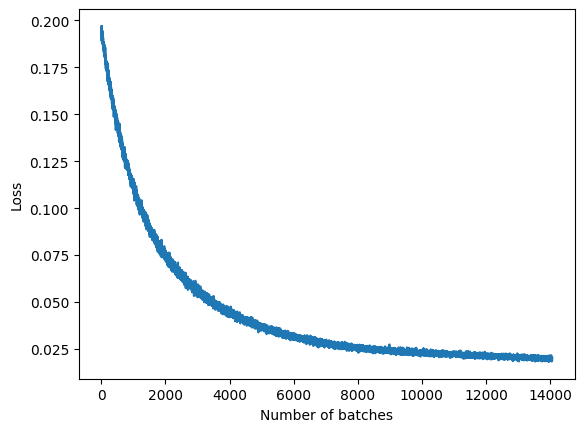

In [9]:
import torch.nn as nn
import torch.optim as optim

# Define the LISTA layer
class LISTALayer(nn.Module):
    def __init__(self):
        super(LISTALayer, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding=1)
        self.conv2 = nn.Conv2d(1, 1, 3, padding=1)
        self.lambda_ = nn.Parameter(torch.rand(1))

    def forward(self, x):
        return x + 0.5 * (torch.sqrt((self.conv1(x) - self.lambda_)**2 + 1) - torch.sqrt((self.conv2(x) + self.lambda_)**2 + 1))

# Define the LISTA model
class LISTAModel(nn.Module):
    def __init__(self):
        super(LISTAModel, self).__init__()
        self.layer1 = LISTALayer()
        self.layer2 = LISTALayer()
        self.layer3 = LISTALayer()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return torch.tanh(x)

# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Create the model and move it to GPU if available
model = LISTAModel().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# Train the model
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    for i, (clean, noisy, _) in enumerate(train_loader):
        # Move data to GPU if available
        noisy, clean = noisy.to(device), clean.to(device)

        # Forward pass
        outputs = model(noisy)
        loss = criterion(outputs, clean)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss
        losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss
plt.plot(losses)
plt.xlabel('Number of batches')
plt.ylabel('Loss')
plt.show()

### (b) [2 pt] Repeat exercise 1b using your trained LISTA.

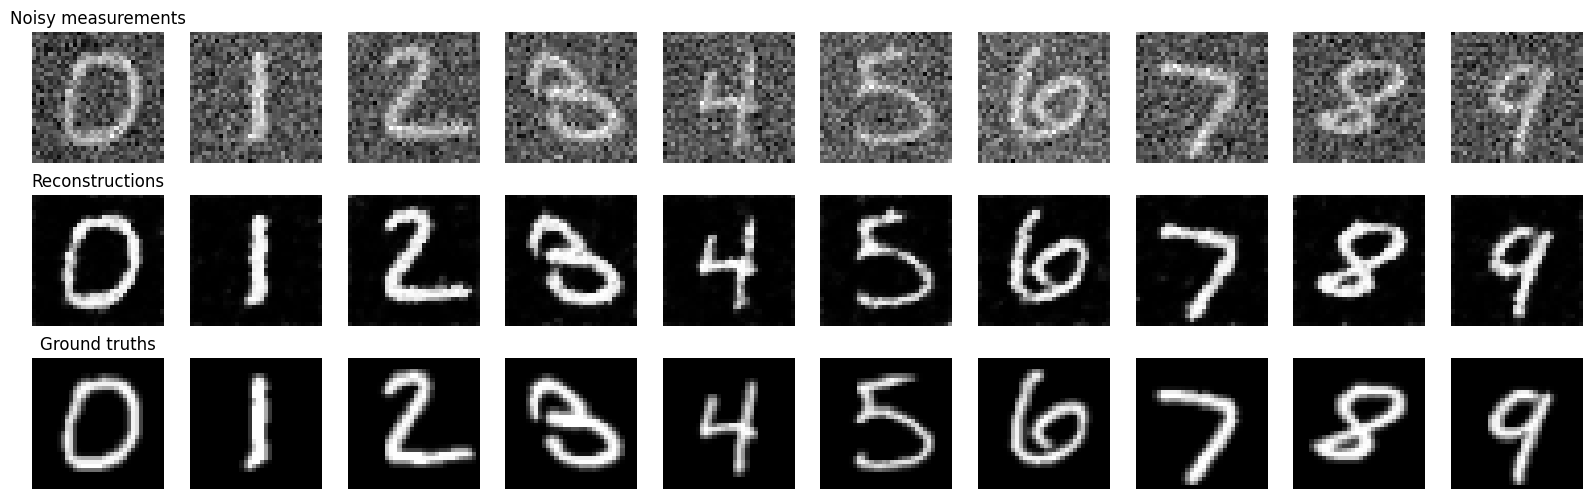

In [25]:
clean, noisy, label = next(iter(test_loader))
output = model(noisy.to(device))

output = output.detach().cpu()
# Access 10 examples as representations for all digits
clean_example = clean[0:10,:,:,:]
noisy_example = noisy[0:10,:,:,:]
output_example = output[0:10,:,:,:]


# Create a figure with 10 columns and 3 rows
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

# For each column
for i in range(10):
    # Display the noisy measurement in the first row
    axs[0, i].imshow(noisy_example[i,0,:,:], cmap='gray')
    axs[0, i].axis('off')
    
    # Display the reconstruction in the second row
    axs[1, i].imshow(output_example[i,0,:,:], cmap='gray')
    axs[1, i].axis('off')
    
    # Display the ground truth in the third row
    axs[2, i].imshow(clean_example[i,0,:,:], cmap='gray')
    axs[2, i].axis('off')

# Set the titles for the rows
axs[0, 0].set_title('Noisy measurements')
axs[1, 0].set_title('Reconstructions')
axs[2, 0].set_title('Ground truths')

# Save the figure
plt.savefig('LISTA_Reconstructions.png')

# Display the figure
plt.show()

### (c) [1 pt] Repeat exercise 1c using your trained LISTA.

In [32]:
model.eval()
loss = []
for batch, (clean,noisy,_) in enumerate(test_loader):
    clean, noisy = clean.to(device),noisy.to(device)



    output = model(noisy)
    x = criterion(output, clean).item()
    loss.append(x)

print(np.mean(loss))


0.019555912513262146


### (d) [1 pt] As you know, neural networks need non-linear activation functions to learn a smarter mapping than just a linear one. 
Where is/are the non-linear activation functions in LISTA, if there even are any?

Answer: [Response here]

---

## Week 2

In [8]:
# define parameters
batch_size = 2
    
train_loader, test_loader = create_dataloaders(data_loc2, batch_size)

# go over the dataset
for i,(kspace, M, gt) in enumerate(tqdm(test_loader)):
    continue

# %% plot the last example
kspace_plot_friendly = torch.log(torch.abs(kspace[0,:,:])+1e-20)

plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(kspace_plot_friendly,vmin=-2.3,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('partial k-space')

plt.subplot(1,3,2)
plt.imshow(M[0,:,:],interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('measurement mask')

plt.subplot(1,3,3)
plt.imshow(gt[0,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('ground truth')

plt.savefig("example.png",dpi=300,bbox_inches='tight')
plt.close()

ValueError: num_samples should be a positive integer value, but got num_samples=0